In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 10

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 42)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             110 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,180 (4.61 KB)

 Trainable params: 1,180 (4.61 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
36/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1002 - loss: 2.4730 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1163 - loss: 2.4143 - val_accuracy: 0.2519 - val_loss: 2.1814
Epoch 2/1000
38/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2153 - loss: 2.1938 
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2143 - loss: 2.1840 - val_accuracy: 0.3059 - val_loss: 2.0218
Epoch 3/1000
38/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2396 - loss: 2.0767 
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2456 - loss: 2.0560 - val_accuracy: 0.3338 - val_loss: 1.8253
Epoch 4/1000
70/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2947 - loss: 1.9096
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras


In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8620 - loss: 0.4838


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
[4.4494912e-01 5.2866329e-02 6.3389908e-03 3.6862803e-05 7.3628705e-03
 9.6795969e-03 8.5788233e-05 1.5170794e-03 4.7712839e-01 3.4920038e-05]
8


# Confusion matrix

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


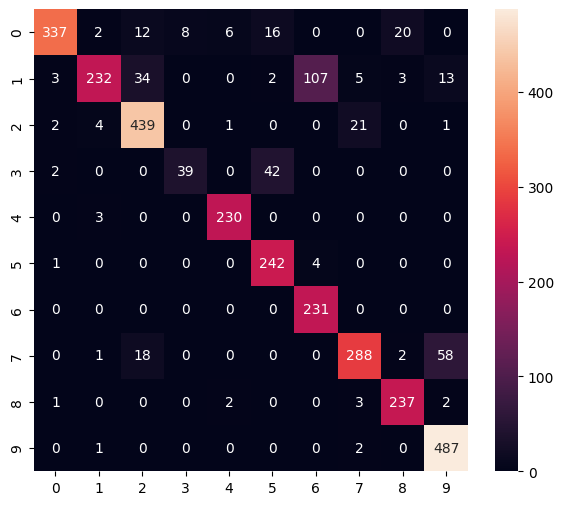

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       401
           1       0.95      0.58      0.72       399
           2       0.87      0.94      0.90       468
           3       0.83      0.47      0.60        83
           4       0.96      0.99      0.97       233
           5       0.80      0.98      0.88       247
           6       0.68      1.00      0.81       231
           7       0.90      0.78      0.84       367
           8       0.90      0.97      0.93       245
           9       0.87      0.99      0.93       490

    accuracy                           0.87      3164
   macro avg       0.87      0.85      0.85      3164
weighted avg       0.89      0.87      0.87      3164



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\yoonh\AppData\Local\Temp\tmpst3owdv3\assets


INFO:tensorflow:Assets written to: C:\Users\yoonh\AppData\Local\Temp\tmpst3owdv3\assets


Saved artifact at 'C:\Users\yoonh\AppData\Local\Temp\tmpst3owdv3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2089242193616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2089241302928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2089241304080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2089241304848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2089246690960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2089246702288: TensorSpec(shape=(), dtype=tf.resource, name=None)


6800

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.4494912e-01 5.2866355e-02 6.3390029e-03 3.6862904e-05 7.3629022e-03
 9.6796136e-03 8.5788393e-05 1.5170823e-03 4.7712839e-01 3.4920169e-05]
8
